In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import mlflow

from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, train_test_split
import xgboost as xgb
import lightgbm as lgbm
import catboost as ca

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import mlflow
import optuna

## EDA & Data Preprocessing

Text(0, 0.5, 'Instances')

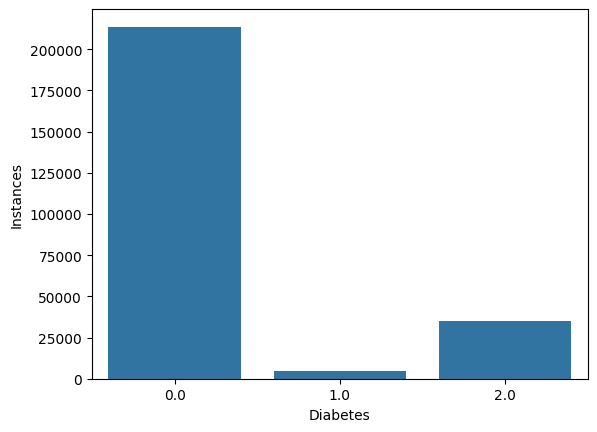

In [62]:
df1 = pd.read_csv('../data/db1.csv')
df2 = pd.read_csv('../data/db2.csv')
df1['Diabetes_binary'].value_counts(normalize=True)

sns.countplot(x='Diabetes_binary', data= df1)
plt.xlabel('Diabetes')
plt.ylabel('Instances')

In [63]:
df1['Diabetes_binary'].info

<bound method Series.info of 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
253675    0.0
253676    2.0
253677    0.0
253678    0.0
253679    2.0
Name: Diabetes_binary, Length: 253680, dtype: float64>

In [64]:
df1['Diabetes_binary'] = df1['Diabetes_binary'].replace({2:1})

df = pd.concat([df1, df2], ignore_index=True)
df['Diabetes_binary'].value_counts(normalize=True)

Diabetes_binary
0.0    0.767788
1.0    0.232212
Name: proportion, dtype: float64

In [65]:
X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

## K-Fold Cross-Validation

In [66]:
KFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Applying data handling & initializing models and OOF array predictions

In [ ]:
smote = SMOTE(random_state=42, sampling_strategy='minority')

# Initial base learners
models = {
    'xgb': xgb.XGBClassifier(eval_metric='logloss', random_state=42),
    'lgbm': lgbm.LGBMClassifier(random_state=42, verbose=-1),
    'catboost': ca.CatBoostClassifier(random_state=42, verbose=0)
}

# Initial OOF predictions
oof_preds = {name: np.zeros(len(X)) for name in models.keys()}
oof_labels = np.zeros(len(X))

# Save folds
all_fold_models = {name: {} for name in models.keys()}
fold_metrics = {name: [] for name in models.keys()}

## Train models with KFold

In [ ]:
mlflow.set_experiment("Diabetes Prediction K-Folds")

for fold, (train_idx, val_idx) in enumerate(KFold.split(X, y)):
    print(f"Fold {fold + 1}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # SMOTE on train set
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        
    # Train and predict for each model
    for name, model in models.items():
        # Clone model to avoid overwriting/leaked data between folds
        with mlflow.start_run(run_name=f'{name}_fold_{fold + 1}'):
            model_clone = sklearn.base.clone(model)
            model_clone.fit(X_train_smote, y_train_smote)
            
            oof_preds[name][val_idx] = model_clone.predict_proba(X_val)[:, 1]
            all_fold_models[name][fold] = model_clone
            
            # Calculate metrics
            fold_pred_proba = model_clone.predict_proba(X_val)[:, 1]
            fold_pred_labels = (fold_pred_proba >= 0.5).astype(int)
            fold_auc = roc_auc_score(y_val, fold_pred_proba)
            fold_accuracy = accuracy_score(y_val, fold_pred_labels)
            fold_recall = recall_score(y_val, fold_pred_labels)
            fold_precision = precision_score(y_val, fold_pred_labels)
            fold_f1 = f1_score(y_val, fold_pred_labels)
            
            # Log metrics
            mlflow.log_param("fold", fold + 1)
            mlflow.log_param("model_type", name)
            mlflow.log_param("smote_strategy", "minority")
            
            mlflow.log_metric("auc", fold_auc)
            mlflow.log_metric("accuracy", fold_accuracy)
            mlflow.log_metric("recall", fold_recall)
            mlflow.log_metric("precision", fold_precision)
            mlflow.log_metric("f1_score", fold_f1)
            
            # Log every model
            #mlflow.sklearn.log_model(model_clone, f"{name}_fold_{fold+1}")
            
            fold_metrics[name].append({
                'fold': fold,
                'auc': fold_auc,
                'val_idx': val_idx
            })
    
    oof_labels[val_idx] = y_val

print("OOF Predictions shape:")
for name, preds in oof_preds.items():
    print(f"  {name}: {preds.shape}")

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
OOF Predictions shape:
  xgb: (324372,)
  lgbm: (324372,)
  catboost: (324372,)


In [ ]:
best_fold_models = {}

for name in models.keys():
    print(f"{'='*50}")
    print(f"{name.upper()}:")
    print(f"{'='*50}")
    
    
    for metric in fold_metrics[name]:
        print(f"  Fold {metric['fold'] + 1}: AUC = {metric['auc']:.4f}")
    
    # Find best fold based on AUC
    best_fold = max(fold_metrics[name], key=lambda x: x['auc'])
    best_fold_idx = best_fold['fold']
    
    print(f"\n  >>> Best Fold: {best_fold_idx + 1} (AUC = {best_fold['auc']:.4f})")
    
    # Save best model
    best_fold_models[name] = all_fold_models[name][best_fold_idx]
    
    print()

XGB:
  Fold 1: AUC = 0.8347
  Fold 2: AUC = 0.8303
  Fold 3: AUC = 0.8310
  Fold 4: AUC = 0.8321
  Fold 5: AUC = 0.8316

  >>> Best Fold: 1 (AUC = 0.8347)

LGBM:
  Fold 1: AUC = 0.8324
  Fold 2: AUC = 0.8281
  Fold 3: AUC = 0.8287
  Fold 4: AUC = 0.8298
  Fold 5: AUC = 0.8298

  >>> Best Fold: 1 (AUC = 0.8324)

CATBOOST:
  Fold 1: AUC = 0.8402
  Fold 2: AUC = 0.8360
  Fold 3: AUC = 0.8371
  Fold 4: AUC = 0.8371
  Fold 5: AUC = 0.8377

  >>> Best Fold: 1 (AUC = 0.8402)



## Comparing folds and choosing the best fold

In [ ]:
# After choosing the best fold
for name, model in best_fold_models.items():
    with mlflow.start_run(run_name=f"{name}_best_model"):
        # Log best model
        mlflow.sklearn.log_model(model, f"{name}_best")
        
        # Evaluate on the whole data
        pred = model.predict(X)
        pred_proba = model.predict_proba(X)[:, 1]
        
        mlflow.log_metric("overall_auc", roc_auc_score(y, pred_proba))
        mlflow.log_metric("overall_accuracy", accuracy_score(y, pred))
        mlflow.log_metric("overall_recall", recall_score(y, pred))
        mlflow.log_metric("overall_precision", precision_score(y, pred))
        mlflow.log_metric("overall_f1", f1_score(y, pred))
        
        # Log best fold info
        best_fold_info = max(fold_metrics[name], key=lambda x: x['auc'])
        mlflow.log_param("best_fold", best_fold_info['fold'] + 1)
        mlflow.log_metric("best_fold_auc", best_fold_info['auc'])

2025/12/26 20:24:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/26 20:25:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/26 20:25:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [ ]:
# Evaluate Best Fold Models
print("=== Best Fold Models Performance ===\n")

for name, model in best_fold_models.items():
    print(f"{'='*50}")
    print(f"{name.upper()} (Best Fold Model):")
    print(f"{'='*50}")
    
    pred = model.predict(X)
    pred_proba = model.predict_proba(X)[:, 1]
    
    print(classification_report(y, pred))
    print(f"ROC-AUC: {roc_auc_score(y, pred_proba):.4f}")
    print(confusion_matrix(y, pred))
    print()

=== Best Fold Models Performance ===

XGB (Best Fold Model):
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87    249049
         1.0       0.59      0.56      0.57     75323

    accuracy                           0.81    324372
   macro avg       0.73      0.72      0.72    324372
weighted avg       0.80      0.81      0.80    324372

ROC-AUC: 0.8426
[[219277  29772]
 [ 33324  41999]]

LGBM (Best Fold Model):
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87    249049
         1.0       0.56      0.56      0.56     75323

    accuracy                           0.80    324372
   macro avg       0.72      0.71      0.71    324372
weighted avg       0.80      0.80      0.80    324372

ROC-AUC: 0.8329
[[216637  32412]
 [ 33330  41993]]

CATBOOST (Best Fold Model):
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.88    249049
         1.0       0

In [ ]:
'''from sklearn.linear_model import LogisticRegression

# === Train Meta-Learner với K-Fold ===
print("=== STACKING ENSEMBLE ===\n")

# Meta features đã có sẵn từ OOF predictions
meta_features = np.column_stack([
    oof_preds['xgb'], 
    oof_preds['lgbm'], 
    oof_preds['catboost']
])

print(f"Meta features shape: {meta_features.shape}")
print(f"Labels shape: {oof_labels.shape}\n")

# Train meta-learner với K-Fold để tránh overfitting
meta_oof_preds = np.zeros(len(meta_features))
meta_models = {}

for fold, (train_idx, val_idx) in enumerate(KFold.split(meta_features, oof_labels)):
    print(f"Meta Fold {fold + 1}")
    
    X_meta_train = meta_features[train_idx]
    X_meta_val = meta_features[val_idx]
    y_meta_train = oof_labels[train_idx]
    
    # Logistic Regression làm meta-learner
    meta_learner = LogisticRegression(
        random_state=42, 
        max_iter=1000,
        solver='lbfgs'
    )
    meta_learner.fit(X_meta_train, y_meta_train)
    
    # OOF predictions cho meta-learner
    meta_oof_preds[val_idx] = meta_learner.predict_proba(X_meta_val)[:, 1]
    meta_models[fold] = meta_learner

print("\n" + "="*60)
print("META-LEARNER PERFORMANCE (OOF)")
print("="*60)

meta_pred_labels = (meta_oof_preds >= 0.5).astype(int)
print(classification_report(oof_labels, meta_pred_labels))
print(f"ROC-AUC: {roc_auc_score(oof_labels, meta_oof_preds):.4f}")
print(confusion_matrix(oof_labels, meta_pred_labels))


# === Train Final Meta-Learner trên toàn bộ data ===
final_meta_learner = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='lbfgs'
)
final_meta_learner.fit(meta_features, oof_labels)

print("\n" + "="*60)
print("META-LEARNER COEFFICIENTS (Feature Importance)")
print("="*60)
for i, name in enumerate(['XGBoost', 'LightGBM', 'CatBoost']):
    coef = final_meta_learner.coef_[0][i]
    print(f"{name:15} : {coef:+.4f}")
print(f"{'Intercept':15} : {final_meta_learner.intercept_[0]:+.4f}")




# === So sánh tất cả models ===
print("\n" + "="*60)
print("FINAL COMPARISON: ROC-AUC SCORES")
print("="*60)

results = {}

# Base learners (OOF)
for name, preds in oof_preds.items():
    results[f"{name.upper()}_oof"] = roc_auc_score(oof_labels, preds)

# Stacking
results['STACKING'] = roc_auc_score(oof_labels, meta_oof_preds)

# Sort và display
for name, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
    bar = '█' * int(score * 50)
    print(f"{name:20} : {score:.4f} {bar}")

# Improvement
best_base = max([results[k] for k in results if k != 'STACKING'])
improvement = (results['STACKING'] - best_base) * 100
print(f"\n✨ Stacking improved by: {improvement:+.2f}%")

'''

Meta features shape: (324372, 3)
Labels shape: (324372,)


## Stacking model

In [ ]:
# Initial stacking feature
meta_features = np.column_stack([
    oof_preds['xgb'], 
    oof_preds['lgbm'], 
    oof_preds['catboost']
])


(324372,)

## Training the Stacking model

In [ ]:
# Train meta-learner with K-Fold
meta_oof_preds = np.zeros(len(meta_features))
meta_models = {}

mlflow.set_experiment("Diabetes Prediction - Stacking")

for fold, (train_idx, val_idx) in enumerate(KFold.split(meta_features, oof_labels)):
    print(f"Meta Fold {fold + 1}")
    
    with mlflow.start_run(run_name=f"meta_learner_fold_{fold+1}"):
        X_meta_train = meta_features[train_idx]
        X_meta_val = meta_features[val_idx]
        y_meta_train = oof_labels[train_idx]
        y_meta_val = oof_labels[val_idx]
        
        # Logistic Regression for meta-learner
        meta_learner = LogisticRegression(
            random_state=42, 
            max_iter=1000,
            solver='lbfgs'
        )
        meta_learner.fit(X_meta_train, y_meta_train)
        
        # OOF predictions for meta-learner
        meta_oof_preds[val_idx] = meta_learner.predict_proba(X_meta_val)[:, 1]
        meta_pred_labels = (meta_learner.predict_proba(X_meta_val)[:, 1] >= 0.5).astype(int)
        
        # Calculate metrics
        fold_auc = roc_auc_score(y_meta_val, meta_oof_preds[val_idx])
        fold_accuracy = accuracy_score(y_meta_val, meta_pred_labels)
        fold_recall = recall_score(y_meta_val, meta_pred_labels)
        fold_precision = precision_score(y_meta_val, meta_pred_labels)
        fold_f1 = f1_score(y_meta_val, meta_pred_labels)
        
        # Log parameters
        mlflow.log_param("fold", fold + 1)
        mlflow.log_param("meta_learner", "LogisticRegression")
        mlflow.log_param("solver", "lbfgs")
        mlflow.log_param("max_iter", 1000)
        mlflow.log_param("base_models", "xgb+lgbm+catboost")
        
        # Log metrics
        mlflow.log_metric("auc", fold_auc)
        mlflow.log_metric("accuracy", fold_accuracy)
        mlflow.log_metric("recall", fold_recall)
        mlflow.log_metric("precision", fold_precision)
        mlflow.log_metric("f1_score", fold_f1)
        
        # Log coefficients
        for i, name in enumerate(['xgb', 'lgbm', 'catboost']):
            mlflow.log_metric(f"coef_{name}", meta_learner.coef_[0][i])
        mlflow.log_metric("intercept", meta_learner.intercept_[0])
        
        meta_models[fold] = meta_learner

print("\n" + "="*60)
print("META-LEARNER PERFORMANCE (OOF)")
print("="*60)

meta_pred_labels = (meta_oof_preds >= 0.5).astype(int)
print(classification_report(oof_labels, meta_pred_labels))
print(f"ROC-AUC: {roc_auc_score(oof_labels, meta_oof_preds):.4f}")
print(confusion_matrix(oof_labels, meta_pred_labels))

2025/12/26 21:15:29 INFO mlflow.tracking.fluent: Experiment with name 'Diabetes Prediction - Stacking' does not exist. Creating a new experiment.


Meta Fold 1
Meta Fold 2
Meta Fold 3
Meta Fold 4
Meta Fold 5

META-LEARNER PERFORMANCE (OOF)
              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88    249049
         1.0       0.63      0.43      0.51     75323

    accuracy                           0.81    324372
   macro avg       0.74      0.68      0.70    324372
weighted avg       0.79      0.81      0.80    324372

ROC-AUC: 0.8376
[[229704  19345]
 [ 42660  32663]]


In [ ]:
# === Train Final Meta-Learner + Log to MLflow ===
with mlflow.start_run(run_name="meta_learner_final"):
    final_meta_learner = LogisticRegression(
        random_state=42,
        max_iter=1000,
        solver='lbfgs'
    )
    final_meta_learner.fit(meta_features, oof_labels)
    
    # Predict on full data
    final_meta_preds = final_meta_learner.predict(meta_features)
    final_meta_proba = final_meta_learner.predict_proba(meta_features)[:, 1]
    
    # Log parameters
    mlflow.log_param("meta_learner", "LogisticRegression")
    mlflow.log_param("solver", "lbfgs")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("base_models", "xgb+lgbm+catboost")
    mlflow.log_param("training_type", "full_data")
    
    # Log overall metrics
    mlflow.log_metric("overall_auc", roc_auc_score(oof_labels, final_meta_proba))
    mlflow.log_metric("overall_accuracy", accuracy_score(oof_labels, final_meta_preds))
    mlflow.log_metric("overall_recall", recall_score(oof_labels, final_meta_preds))
    mlflow.log_metric("overall_precision", precision_score(oof_labels, final_meta_preds))
    mlflow.log_metric("overall_f1", f1_score(oof_labels, final_meta_preds))
    
    # Log OOF metrics
    mlflow.log_metric("oof_auc", roc_auc_score(oof_labels, meta_oof_preds))
    
    # Log coefficients
    for i, name in enumerate(['xgb', 'lgbm', 'catboost']):
        coef = final_meta_learner.coef_[0][i]
        mlflow.log_metric(f"final_coef_{name}", coef)
        print(f"{name.upper():15} : {coef:+.4f}")
    mlflow.log_metric("final_intercept", final_meta_learner.intercept_[0])
    print(f"{'Intercept':15} : {final_meta_learner.intercept_[0]:+.4f}")
    
    # Log model
    mlflow.sklearn.log_model(final_meta_learner, "meta_learner_final")
    
    # Log meta_features as artifact
    meta_features_df = pd.DataFrame(
        meta_features, 
        columns=['xgb_pred', 'lgbm_pred', 'catboost_pred']
    )
    meta_features_df['true_label'] = oof_labels
    meta_features_df.to_csv('meta_features.csv', index=False)
    mlflow.log_artifact('meta_features.csv')

2025/12/26 21:15:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


XGB             : +0.6751
LGBM            : -0.0883
CATBOOST        : +4.9214
Intercept       : -3.0955


In [ ]:
# === Compare models ===
print("\n" + "="*60)
print("FINAL COMPARISON: ROC-AUC SCORES")
print("="*60)

results = {}

# Base learners (OOF)
for name, preds in oof_preds.items():
    results[f"{name.upper()}_oof"] = roc_auc_score(oof_labels, preds)

# Stacking
results['STACKING'] = roc_auc_score(oof_labels, meta_oof_preds)

# Sort and display
for name, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
    bar = '█' * int(score * 50)
    print(f"{name:20} : {score:.4f} {bar}")

# Improvement
best_base = max([results[k] for k in results if k != 'STACKING'])
improvement = (results['STACKING'] - best_base) * 100
print(f"\n✨ Stacking improved by: {improvement:+.2f}%")

# Log comparison to MLflow
with mlflow.start_run(run_name="model_comparison"):
    for name, score in results.items():
        mlflow.log_metric(f"auc_{name.lower()}", score)
    mlflow.log_metric("improvement_percentage", improvement)


FINAL COMPARISON: ROC-AUC SCORES
CATBOOST_oof         : 0.8376 █████████████████████████████████████████
STACKING             : 0.8376 █████████████████████████████████████████
XGB_oof              : 0.8319 █████████████████████████████████████████
LGBM_oof             : 0.8297 █████████████████████████████████████████

✨ Stacking improved by: -0.01%
